In [1]:
!pip install nangs

# u_x + x*x*y*u_y - u = 1
# u(0,y) = y^3

import numpy as np
import matplotlib.pyplot as plt
import nangs
import torch

from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

class Equation(PDE):
    def computePDELoss(self, inputs, outputs):
        
        x, y=inputs[:,0], inputs[:,1]
        u = outputs[:, 0]
        
        #compute gradients
        grads=self.computeGrads(outputs, inputs)
        
        #compute loss
        dudx, dudy=grads[:, 0], grads[:, 1]
        return {'pde': dudx + x*x*y*dudy - u - 1}
    
pde=Equation(inputs=('x', 'y'), outputs='u')

In [2]:
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)

mesh = Mesh({'x': x, 'y': y}, device=device)
pde.set_mesh(mesh)

In [3]:
# boundary conditions

x1 = np.array([0])
u = np.full(len(y), y*y*y)
boco = Dirichlet({'x': x1, 'y': y}, {'u': u.reshape(-1)}, name='initial', 
                 device=device)
pde.add_boco(boco)

In [4]:
BATCH_SIZE = 16
LR = 2e-4
EPOCHS = 1000
NUM_LAYERS = 16
NUM_HIDDEN = 512

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                 pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

CPU times: user 6min 58s, sys: 6.58 s, total: 7min 4s
Wall time: 7min 23s


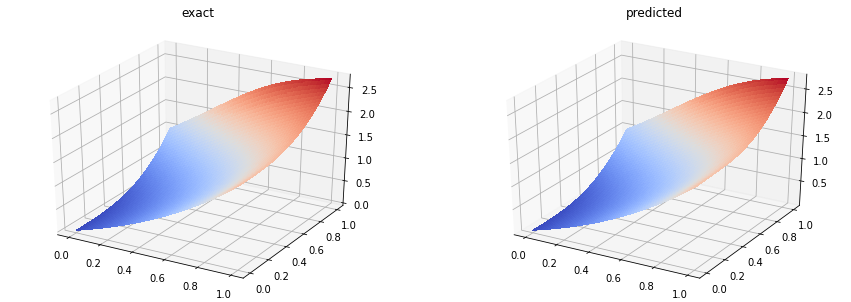

L2 error:  0.7456260297281583 %


In [5]:
# evaluate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
eval_mesh=Mesh({'x': x,'y': y}, device=device)

u=pde.eval(eval_mesh)
u=u.cpu().numpy()

_x, _y=np.meshgrid(x,y)
u0=((_y**3)*np.exp(-_x**3)+1)*np.exp(_x)-1

fig=plt.figure(figsize=(15, 5))
ax1=fig.add_subplot(1,2,1,projection='3d')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax1.plot_surface(_x, _y, u0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                 linewidth=0, antialiased=False)
ax1.title.set_text('exact')
ax2.plot_surface(_x, _y, u.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                 linewidth=0, antialiased=False)
ax2.title.set_text('predicted')
plt.show()
print("L2 error: ", np.sqrt(sum((u0.ravel()-u.ravel())**2))
      /np.sqrt(sum(u0.ravel()**2))*100,"%")

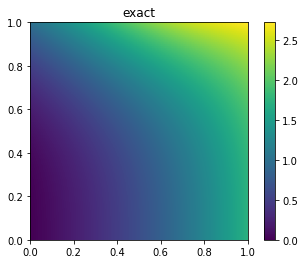

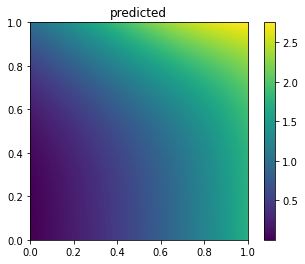

In [6]:
plt.imshow(u0.reshape(len(y),len(x)), vmin=u0.min(), vmax=u0.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.title('exact')
plt.show()

plt.imshow(u.reshape((len(y),len(x))), vmin=u.min(), vmax=u.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.title('predicted')
plt.show()

In [7]:
# experiment on changes with 5 variables

# u_x + x*x*y*u_y - u = 1
# u(0,y) = y^3

import numpy as np
import matplotlib.pyplot as plt
import nangs
import torch

from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

class Equation(PDE):
    def computePDELoss(self, inputs, outputs):
        
        x, y=inputs[:,0], inputs[:,1]
        u = outputs[:, 0]
        
        #compute gradients
        grads=self.computeGrads(outputs, inputs)
        
        #compute loss
        dudx, dudy=grads[:, 0], grads[:, 1]
        return {'pde': dudx + x*x*y*dudy - u - 1}
    
pde=Equation(inputs=('x', 'y'), outputs='u')

In [8]:
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)

mesh = Mesh({'x': x, 'y': y}, device=device)
pde.set_mesh(mesh)

In [9]:
# boundary conditions

x1 = np.array([0])
u = np.full(len(y), y*y*y)
boco = Dirichlet({'x': x1, 'y': y}, {'u': u.reshape(-1)}, name='initial', 
                 device=device)
pde.add_boco(boco)

In [10]:
BATCH_SIZE = 32
LR = 2e-4
EPOCHS = 200
NUM_LAYERS = 36
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

CPU times: user 1min 10s, sys: 809 ms, total: 1min 11s
Wall time: 1min 13s
